In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from pymlx import *
import time

Load data

In [2]:
train_file = '../data/census_income.train.csv'
test_file = '../data/census_income.test.csv'
label_col = 'Income >50K'

train_df, _ = utils.load_data(train_file, label_col)
# suggested_handlers = suggest_handlers(train_df)

feat = Featurizer(
    categorical = ['Education', 'Marital Status'],
    one_hot = ['Native Country', 'Occupation', 'Race', 'Relationship Status', 'Sex', 'Workclass'],
    binning = ['Age', 'Capital Gain', 'Hours per week', 'Years in Education', 'Capital Loss']
)


Learn features

In [3]:
start_timing()
feat.learn(train_file) # in case the train data is large, the featurizer only needs to be trained on sampled data
train_features, train_labels = utils.load_featurized_data(train_file, label_col, feat, return_dataframe=True
                                                         )
report_timing()

Elapsed: 0.06 minutes


In [4]:
dffeats2npfeats(train_features).shape

(25000, 86)

Find the best params

In [4]:
import xgboost
import lightgbm

In [5]:
start_timing()
sweeper = random_sweep(
    train_features, train_labels, 
    lightgbm.LGBMClassifier(), {
                      'max_depth': [3, 5, 10, 20], 
                      'n_estimators': [10, 20, 40, 80],
                      'subsample': [1, 0.8]},
    scoring=pr_scorer, n_iter=10, verbose=1)
report_timing()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Elapsed: 0.096 minutes


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.8s finished


Training

In [7]:
start_timing()
predictor = xgboost.XGBClassifier(n_estimators=80, max_depth=10, subsample=0.8)
predictor.fit(np.array(train_features.values.tolist()), train_labels) # refit the model on full data
report_timing()

# Combine featurizer and predictor to make an end-to-end model
model = BinaryClassifier(predictor, feat)

Elapsed: 0.17 minutes


Testing

In [12]:
test_df, test_labels = load_data(test_file, label_col)
predictions, raw = model.bulk_predict(test_df)

In [13]:
predictions

array([0.04505242, 0.00176057, 0.01116952, ..., 0.02452752, 0.00102975,
       0.99575657], dtype=float32)

In [15]:
raw[0][0] + raw[0][1]

1.0

Result

In [14]:
confusion_matrix(test_labels, predictions)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

Feature importance

In [11]:
fscores = model.get_fscores()
fscores.head(10)

Age_bin                       2324
Hours per week_bin            1506
Education_ide                  760
Years in Education_bin         631
Capital Gain_bin               571
Capital Loss_bin               551
Marital Status_ide             285
Workclass=Private              281
Occupation=Exec-managerial     256
Occupation=Prof-specialty      240
dtype: int64

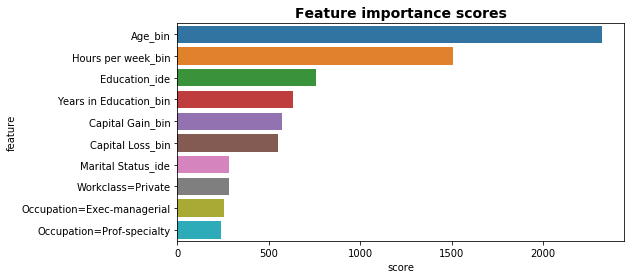

In [15]:
visualize_feature_importance(fscores.to_dict(), 10, fig_height=4)

Feature density to the target

In [16]:
features = train_features.copy()
features['Target'] = train_labels

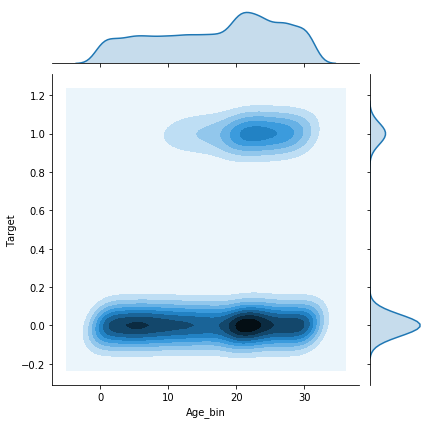

In [17]:
visualize_feat_density(features, 'Age_bin', 'Target')

In [18]:
diagnostics = diagnose(model, test_df, test_labels, predictions=predictions)
diagnostics.head(10)

,Labeled,Predicted Probability,Education Ide,Marital Status Ide,Native Country=United-States,Native Country=Cuba,Native Country=Jamaica,Native Country=India,Native Country=?,Native Country=Mexico,...,Workclass=Local-Gov,Workclass=?,Workclass=Self-Emp-Inc,Workclass=Without-Pay,Workclass=Never-Worked,Age Bin,Capital Gain Bin,Hours Per Week Bin,Years In Education Bin,Capital Loss Bin
7214,1,0.002724,11,0,0,0,0,0,0,0,...,1,0,0,0,0,4,0,7,3,0
149,1,0.003499,8,0,0,0,0,0,0,1,...,0,0,0,0,0,15,0,7,4,0
4919,1,0.007949,5,1,1,0,0,0,0,0,...,0,0,0,0,0,5,0,7,10,0
1492,1,0.008024,0,0,1,0,0,0,0,0,...,0,0,0,0,0,8,0,7,13,0
1681,1,0.010045,1,6,1,0,0,0,0,0,...,0,1,0,0,0,31,0,3,9,0
6512,1,0.011058,1,0,1,0,0,0,0,0,...,0,0,0,0,0,9,0,14,9,0
4618,1,0.012937,1,2,1,0,0,0,0,0,...,0,0,0,0,0,23,0,7,9,0
1027,1,0.012971,1,0,1,0,0,0,0,0,...,0,0,0,0,0,15,0,7,9,0
5306,1,0.013434,1,2,1,0,0,0,0,0,...,0,0,0,0,0,19,0,7,9,0
5572,1,0.015587,6,6,1,0,0,0,0,0,...,0,0,0,0,0,11,0,7,12,0
